In [5]:
from fastai import datasets
import PIL, os, mimetypes, sys
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch.optim import SGD
import math

from collections import OrderedDict
from functools import partial

from toss.utils import listify
from toss.containers import ListContainer
from toss.data import DataBunch
from toss.callbacks import AvgStatsCallback, CudaCallback, BatchTransformCallback, ParamScheduler
from toss.layers import Lambda, BatchNorm, GeneralReLU, Flatten
from toss.train import Trainer
from toss.scheduling import combine_scheds, sched_cos

Path.ls = lambda x: list(x.iterdir())

In [6]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160')

In [7]:
Path(path/'val').ls()

[WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160/val/n01440764'),
 WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160/val/n02102040'),
 WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160/val/n02979186'),
 WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160/val/n03000684'),
 WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160/val/n03028079'),
 WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160/val/n03394916'),
 WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160/val/n03417042'),
 WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160/val/n03425413'),
 WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160/val/n03445777'),
 WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160/val/n03888257')]

In [8]:
cat_path = Path(path/'val'/'n02102040')
img = cat_path.ls()[0]
img

WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160/val/n02102040/ILSVRC2012_val_00004650.JPEG')

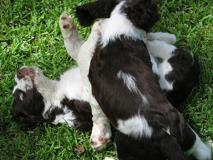

In [9]:
PIL.Image.open(cat_path/img)

In [10]:
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith("image/"))
" ".join(image_extensions)

'.tiff .jpeg .tif .ico .xwd .png .ief .gif .xbm .xpm .svg .pbm .pgm .jpe .jpg .pnm .ppm .rgb .ras .bmp'

In [11]:
def setify(o):
    return o if isinstance(o, set) else set(listify(o))

In [12]:
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
    and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [13]:
t = [o.name for o in os.scandir(cat_path)]
t = _get_files(path, t, extensions = image_extensions)
t[:3]

[WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160/ILSVRC2012_val_00004650.JPEG'),
 WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160/ILSVRC2012_val_00007032.JPEG'),
 WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160/ILSVRC2012_val_00008162.JPEG')]

In [14]:
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for p, d, f in os.walk(path):
            if include is not None:
                d[:] = [o for o in d if o in include]
            else:
                d[:] = [o for o in d if o if not o.startswith(".")]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [15]:
get_files(cat_path, image_extensions)[:3]

[WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160/val/n02102040/ILSVRC2012_val_00004650.JPEG'),
 WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160/val/n02102040/ILSVRC2012_val_00007032.JPEG'),
 WindowsPath('C:/Users/daddu/.fastai/data/imagenette2-160/val/n02102040/ILSVRC2012_val_00008162.JPEG')]

In [16]:
len(get_files(path, image_extensions, recurse = True))

KeyboardInterrupt: 

In [ ]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

In [ ]:
def compose(x, funcs, *args, order_key="ORDER", **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key):
        x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
    def __init__(self, items, path=".", tfms=None):
        super().__init__(items)
        self.path = path
        self.tfms = tfms
        
    def __repr__(self):
        return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items):
        return self.__class__(items, self.path, tfms=self.tfms)
    
    def get(self, i):
        return i
    
    def _get(self, i):
        return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res, list):
            return [self._get(o) for o in res]
        return self._get(res)
    
class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None:
            extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fname):
        return PIL.Image.open(fname)
    
    

In [ ]:
class Transform():
    ORDER = 0
    
class MakeRGB(Transform):
    def __call__(self, item):
        return item.convert("RGB")

In [ ]:
il = ImageList.from_files(path, tfms=MakeRGB())

In [ ]:
il

In [ ]:
il[0]

In [ ]:
def grandparent_splitter(fn, valid_name="valid", train_name="train"):
    gp = fn.parent.parent.name
    return True if gp == valid_name else False if gp == train_name else None

def split_by_func(ds, f):
    items = ds.items
    mask = [f(o) for o in items]
    train = [o for o, m in zip(items, mask) if m == False]
    valid = [o for o, m in zip(items, mask) if m == True]
    return train, valid


In [ ]:
splitter = partial(grandparent_splitter, valid_name = "val")

In [ ]:
%time train, valid = split_by_func(il, splitter)

In [ ]:
len(train), len(valid), len(train) + len(valid)

In [ ]:
class SplitData():
    def __init__(self, train, valid):
        self.train = train
        self.valid = valid
        
    def __getattr__(self, k):
        return getattr(self.train, k)
    
    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il, f))
        return cls(*lists)
    
    def __repr__(self):
        return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [ ]:
sd = SplitData.split_by_func(il, splitter); sd

In [ ]:
def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort:
        res.sort()
    return res

class Processor():
    def process(self, items):
        return items
    
class CategoryProcessor(Processor):
    def __init__(self):
        self.vocab  = None
        
    def process(self, items):
        if self.vocab is None:
            self.vocab =uniqueify(items)
            #  object to int
            self.otoi = {v: k for k , v in enumerate(self.vocab)}
        return [self._process(o) for o in items]
    
    def _process(self, item):
        return self.otoi[item]
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        if not isinstance(idxs, list):
            idxs = [idxs]
        return [self._deprocess(idx) for idx in idxs]
    
    def _deprocess(self, idx):
        return self.vocab[idx]
    
class ProcessedItemList(ListContainer):
    def __init__(self, inputs, processor):
        self.proc = processor
        items = processor.process(inputs)
        super().__init__(items)
        
    def obj(self, idx):
        return self.proc.deprocess(self[idx])


In [ ]:
def parent_labeler(fn):
    return fn.parent.name

def _label_by_func(ds, f):
    return [f(o) for o in ds.items]

class LabeledData():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __repr(self):
        return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}'
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.x)
        
    @classmethod
    def label_by_func(cls, il, f, proc=None):
        labels = _label_by_func(il, f)
        proc_labels = ProcessedItemList(labels, proc)
        return cls(il, proc_labels)
    
    
def label_by_func(sd, f):
    proc = CategoryProcessor()
    train = LabeledData.label_by_func(sd.train, f, proc)
    valid = LabeledData.label_by_func(sd.valid, f, proc)
    return SplitData(train, valid)


In [ ]:
il = label_by_func(sd, parent_labeler)

In [ ]:
assert il.train.y.proc is il.valid.y.proc

In [ ]:
il.train.y.items[0],  il.train.y.obj(0)

In [ ]:
il.train[0]

In [ ]:
class ResizeFixed(Transform):
    ORDER= 10
    def __init__(self, size):
        if isinstance(size, int):
            self.size = (size, size)
        
    def __call__(self, item):
        return item.resize(self.size, PIL.Image.BILINEAR)
    
class ConvertToByteTensor(Transform):
    ORDER= 20
    def __call__(self, item):
        res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
        w, h = item.size
        return res.view(h, w, -1).permute(2,0,1)
    
class ConvertToFloatTensor(Transform):
    ORDER= 30
    def __call__(self, item):
        return item.float().div_(255.)

In [ ]:
tfms = [MakeRGB(), ResizeFixed(128), 
        ConvertToByteTensor(), ConvertToFloatTensor()]

il =  ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
il = label_by_func(sd, parent_labeler)

In [ ]:
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(im.permute(1,2,0))
    

In [ ]:
x,y = next(iter(data.train_gen))
x.shape

In [ ]:
show_image(x[0])

In [ ]:
n_classes = len(Path(path/'val').ls()); n_classes

In [ ]:
data = DataBunch(il.train, il.valid, batch_size=64,
                 n_input=3, n_output=n_classes)

In [ ]:
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]

In [ ]:
m, s = x.mean((0,2,3)).cuda(), x.std((0,2,3)).cuda()
m,s

In [ ]:
_m = torch.tensor([0.4688, 0.4666, 0.4312])
_s = torch.tensor([0.2699, 0.2663, 0.2855])
norm_imagenette = partial(normalize_chan, mean=_m, std=_s)

In [ ]:
cbfs = [
    partial(AvgStatsCallback, accuracy),
    partial(BatchTransformCallback, norm_imagenette)]

In [ ]:
nfs = [32, 64, 128, 256]

In [ ]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [torch.nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralReLU(**kwargs)]
    if bn: 
        layers.append(BatchNorm(nf))
    return torch.nn.Sequential(*layers)

def prev_pow_2(x):
    return 2**math.floor(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2):
        return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.n_input
    l2 = prev_pow_2(l1*3*3)
    layers= [f(l1,   l2,   stride=1),
             f(l2,   l2*2, stride=2),
             f(l2*2, l2*4, stride=2)]
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [torch.nn.AdaptiveAvgPool2d(1), Lambda(flatten),
              torch.nn.Linear(nfs[-1], data.n_output)]
    return layers
    
def get_cnn_model(data, nfs, layer, **kwargs):
    return torch.nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [ ]:
def get_trainer(data, nfs, cbfs, layer, lr, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    opt = SGD(model.parameters(), lr=lr)
    init_cnn(model)
    trainer = Trainer(model, data, torch.nn.functional.cross_entropy, 
                      opt=opt, cbs=cbfs)
    return trainer

In [ ]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.1,0.3),sched_cos(0.3,0.05)])

In [ ]:
cbfs.append(partial(ParamScheduler, "lr", sched))

In [ ]:
trainer = get_trainer(data=data, nfs=nfs, layer=conv_layer, 
                     cbfs = cbfs, lr=0.4)

In [ ]:
%time trainer.fit(5)

### Optimizer

In [ ]:
def get_defaults(d):
    return getattr(d, "DEFAULTS", {})

def check_defaults(steppers, defaults, f):
    for stepper in steppers:
        for param, value in f(stepper).items():
            if param not in defaults:
                defaults[param] = value


class Optimizer:
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        check_defaults(self.steppers, defaults, get_defaults)

        self.param_groups = list(params)
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]

        self.hypers = [{**defaults} for _ in self.param_groups]

    def grad_params(self):
        params = []
        for pg, hyper in zip(self.param_groups, self.hypers):
            for p in pg:
                if p.grad is not None:
                    params.append((p, hyper))
        return params

    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p, hyper in self.grad_params():
            compose(p, self.steppers, **hyper)


In [ ]:
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

In [ ]:
opt = partial(Optimizer, steppers=[sgd_step])

In [ ]:
class Recorder(Callback):
    def begin_fit(self): 
        self.lrs = []
        self.losses = []

    def after_batch(self):
        if not self.in_train:
            return
        
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self):
        plt.plot(self.lrs)
        
    def plot_loss(self):
        plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname = pname
        self.sched_funcs = listify(sched_funcs)

    def begin_batch(self): 
        if not self.in_train:
            return
        
        fs = self.sched_funcs
        if len(fs)==1:
            fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs,self.opt.hypers):
            h[self.pname] = f(pos)
            
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter = max_iter
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train:
            return
        pos = self.n_iter / self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: 
            pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: 
            self.best_loss = self.loss

In [ ]:
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1-lr*wd)
    return p
weight_decay.DEFAULTS = dict(wd=0.)

In [ ]:
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults):
        self.stats= listify(stats)
        check_update(self.stats, defaults)
        super().__init__(params, steppers, **defaults, get_defaults)
        self.state = {}
        
    def step(self):
        for p, hyper in self.grad_params():
            if p not in self.state:
                self.state[p] = {}
                check_update(self.stats, self.state[p], lambda o: o.init_state(p))
            state = self.state[p]
            for stat in self.stats:
                state = stat.update(p, state, **hyper)
            compose(p, self.steppers, **state, **hyper)
            self.state[p] = state

In [ ]:
class Stat():
    DEFAULTS = {}
    def init_state(self, p):
        raise NotImplementedError
    def update(self, p, state, **kwargs):
        raise NotImplementedError

In [ ]:
class AverageGrad(Stat):
    DEFAULTS = dict(mom=0.9)
    
    def init_state(self, p):
        return {"grad_avg": torch.zeros_like(p.grad.data)}
    
    def update(self, p, state, mom, **kwargs):
        state["grad_avg"].mul_(mom).add_(p.grad.data)
        return state

In [ ]:
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)
    return p

In [ ]:
def mom1(avg, beta, yi, i):
    if avg is None:
        avg = yi
    res = beta*avg + yi
    return res

In [ ]:
def ewma(v1,v2,beta):
    return beta*v1 + (1-beta)*v2

def mom2(avg, beta, yi, i):
    if avg is None:
        avg = yi
    res = ewma(avg, yi, beta)
    return res

In [ ]:
def mom2(avg, beta, yi, i):
    if avg is None:
        avg = 0
    avg = ewma(avg, yi, beta)
    return avg / (1-beta**(i+1))

In [ ]:
class AverageGrad(Stat):
    DEFAULTS = dict(mom=0.9)
    
    def __init__(self, damp=False):
        self.damp = damp
        
    def init_state(self, p):
        return {"grad_avg": torch.zeros_like(p.grad.data)}
    
    def update(self, p, state, mom, **kwargs):
        state["mom_damp"] = 1-mom if  self.damp else 1.
        state["grad_avg"].mul_(mom).add_(state["mom_damp"], p.grad.data)
        return state

In [ ]:
class AverageSqrGrad(Stat):
    DEFAULTS = dict(mom=0.99)
    
    def __init__(self, damp=False):
        self.damp = damp
        
    def init_state(self, p):
        return {"sqr_avg": torch.zeros_like(p.grad.data)}
    
    def update(self, p, state, sqr_mom, **kwargs):
        state["sqr_damp"] = 1-sqr_mom if  self.damp else 1.
        state["sqr_avg"].mul_(sqr_mom).addcmul_(state["sqr_damp"], p.grad.data, p.grad.data)
        return state

In [ ]:
class StepCount(Stat):
    def init_state(self, p):
        return {"step": 0}
    
    def update(self, p, state, mom, **kwargs):
        state["step"] +=1
        return state

In [ ]:
def debias(mom, damp, step):
    return damp * (1- mom**step) / (1-mom)

In [ ]:
def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom, mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    p.data.addcdiv_(-lr / debias1, grad_avg, (sqr_avg/debias2).sqrt()+ eps)
    return p
adam_step.DEFAULTS = dict(eps=1e-5)

In [ ]:
def lamb_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, wd, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    r1 = p.data.pow(2).mean().sqrt()
    step = (grad_avg/debias1) / ((sqr_avg/debias2).sqrt()+eps) + wd*p.data
    r2 = step.pow(2).mean().sqrt()
    p.data.add_(-lr * min(r1/r2,10), step)
    return p
lamb_step._defaults = dict(eps=1e-6, wd=0.)

In [ ]:
class ProgressCallback(Callback):
    ORDER = -1
    def begin_fit(self):
        self.mbar = master_bar(range(self.epochs))
        self.mbar.on_iter_begin()
        self.trainer.logger = partial(self.mbar.write, table=True)
        
    def after_fit(self):
        self.mbar.on_iter_end()
    
    def after_batch(self):
        self.pb.update(self.iter)
        
    def begin_epoch(self):
        self.set_pb()
        
    def begin_validate(self):
        self.set_pb()
        
    def set_pb(self):
        self.pb = progress_bar(self.dl, parent=self.mbar, auto_update=False)
        self.mbar.update(self.epoch)